In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import json

import statsmodels.api as sm
from ast import literal_eval
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

#pd.options.display.max_rows = None
#pd.options.display.max_columns = 100

# Data Cleaning

Importing credit, keywords, links, movie and ratings tables <br>
Merge these dataframes to get one dataframe

# Recommendation Engine Dataset

In [2]:
credits = pd.read_csv('the-movies-dataset/credits.csv')
keywords = pd.read_csv('the-movies-dataset/keywords.csv')
links = pd.read_csv('the-movies-dataset/links.csv')
movie = pd.read_csv('the-movies-dataset/movies_metadata.csv')
ratings = pd.read_csv('the-movies-dataset/ratings.csv')

### Check for null values

In [3]:
credits.isnull().sum()

cast    0
crew    0
id      0
dtype: int64

In [4]:
keywords.isnull().sum()

id          0
keywords    0
dtype: int64

In [5]:
links.isnull().sum()

movieId      0
imdbId       0
tmdbId     219
dtype: int64

In [6]:
x = movie.loc[movie['imdb_id'].isnull()].reset_index()
for i in range(0,len(x)):
    display(links.loc[links['tmdbId'] == float(x['id'][i])])
   

,movieId,imdbId,tmdbId
9015,26723,101704,36337.0


,movieId,imdbId,tmdbId
13833,69203,358146,200796.0


,movieId,imdbId,tmdbId
13897,69489,65908,75015.0


,movieId,imdbId,tmdbId
17504,87962,818098,36663.0


,movieId,imdbId,tmdbId
17632,88414,118174,47116.0


,movieId,imdbId,tmdbId
19108,94735,490048,28500.0


,movieId,imdbId,tmdbId
19485,96347,2039333,118013.0


,movieId,imdbId,tmdbId
20999,102058,1325753,15257.0


,movieId,imdbId,tmdbId
21132,102497,119501,55576.0


,movieId,imdbId,tmdbId
22128,105978,112563,293412.0


,movieId,imdbId,tmdbId
23239,109874,493101,45514.0


,movieId,imdbId,tmdbId
24019,112807,98492,30146.0


,movieId,imdbId,tmdbId
34071,144448,2076298,324017.0


,movieId,imdbId,tmdbId
37287,153736,81684,161535.0


,movieId,imdbId,tmdbId
41165,164749,491603,65256.0


,movieId,imdbId,tmdbId
42196,167424,4699464,430514.0


,movieId,imdbId,tmdbId
45446,175335,6051554,439314.0


In [7]:
links = links.dropna()
links = links.astype('int64')
links.head(1)

,movieId,imdbId,tmdbId
0,1,114709,862


In [8]:
links.isnull().sum()

movieId    0
imdbId     0
tmdbId     0
dtype: int64

In [9]:
movie.isnull().sum()

adult                        0
belongs_to_collection    40972
budget                       0
genres                       0
homepage                 37684
id                           0
imdb_id                     17
original_language           11
original_title               0
overview                   954
popularity                   5
poster_path                386
production_companies         3
production_countries         3
release_date                87
revenue                      6
runtime                    263
spoken_languages             6
status                      87
tagline                  25054
title                        6
video                        6
vote_average                 6
vote_count                   6
dtype: int64

In [10]:
display(movie[19730:19731])
movie['id'] = movie['id'].apply( lambda x: re.sub('-', '', x))
movie['id'] = movie['id'].astype('int64')

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
19730,- Written by Ørnås,0.065736,/ff9qCepilowshEtG2GYWwzt2bs4.jpg,"[{'name': 'Carousel Productions', 'id': 11176}...","[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",1997-08-20,0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
df = pd.merge(movie, links, left_on='id', right_on='tmdbId')
df = pd.merge(df, keywords, left_on='tmdbId', right_on='id')
df = pd.merge(df, credits, left_on='tmdbId', right_on='id')

In [12]:
df.head(2) 

,adult,belongs_to_collection,budget,genres,homepage,id_x,imdb_id,original_language,original_title,overview,...,vote_average,vote_count,movieId,imdbId,tmdbId,id_y,keywords,cast,crew,id
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,7.7,5415.0,1,114709,862,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...","[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,6.9,2413.0,2,113497,8844,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1...","[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844


### Remove Punctuation

In [13]:
df['new_genres'] = df['genres'].fillna('[]').apply(literal_eval).apply(lambda x:
                                        [i['name'] for i in x] if isinstance(x, list) else [])

df['new_genres'] = df['new_genres'].apply(lambda x: str(x).strip('[]'))

In [14]:
df['new_production_companies'] = df['production_companies'].fillna('[]').apply(literal_eval).apply(lambda x:
                                        [i['name'] for i in x] if isinstance(x, list) else [])

df['new_production_companies'] = df['new_production_companies'].apply(lambda x: str(x).strip('[]'))

In [15]:
df['new_production_countries'] = df['production_countries'].fillna('[]').apply(literal_eval).apply(lambda x:
                                        [i['name'] for i in x] if isinstance(x, list) else [])

df['new_production_countries'] = df['new_production_countries'].apply(lambda x: str(x).strip('[]'))

In [16]:
df['new_spoken_languages'] = df['spoken_languages'].fillna('[]').apply(literal_eval).apply(lambda x:
                                        [i['name'] for i in x] if isinstance(x, list) else [])

df['new_spoken_languages'] = df['new_spoken_languages'].apply(lambda x: str(x).strip('[]'))

In [17]:
df['new_keywords'] = df['keywords'].fillna('[]').apply(literal_eval).apply(lambda x:
                                        [i['name'] for i in x] if isinstance(x, list) else [])

df['new_keywords'] = df['new_keywords'].apply(lambda x: str(x).strip('[]'))

In [18]:
df['new_cast'] = df['cast'].fillna('[]').apply(literal_eval).apply(lambda x:
                                        [i['name'] for i in x] if isinstance(x, list) else [])

df['new_cast'] = df['new_cast'].apply(lambda x: str(x).strip('[]'))

In [19]:
df.head(2)

,adult,belongs_to_collection,budget,genres,homepage,id_x,imdb_id,original_language,original_title,overview,...,keywords,cast,crew,id,new_genres,new_production_companies,new_production_countries,new_spoken_languages,new_keywords,new_cast
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...","[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862,"'Animation', 'Comedy', 'Family'",'Pixar Animation Studios','United States of America','English',"'jealousy', 'toy', 'boy', 'friendship', 'frien...","'Tom Hanks', 'Tim Allen', 'Don Rickles', 'Jim ..."
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,"[{'id': 10090, 'name': 'board game'}, {'id': 1...","[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844,"'Adventure', 'Fantasy', 'Family'","'TriStar Pictures', 'Teitler Film', 'Interscop...",'United States of America',"'English', 'Français'","'board game', 'disappearance', ""based on child...","'Robin Williams', 'Jonathan Hyde', 'Kirsten Du..."


### Remove Duplicate Columns

In [20]:
df = df.drop(columns = ['belongs_to_collection', 'budget','genres','homepage','release_date',
                        'id_x','imdb_id','poster_path','production_companies', 'status',
                        'production_countries','spoken_languages','title','runtime','video',
                        'movieId','id_y','keywords','cast','crew','id','revenue'],axis = 1)

In [21]:
df.head(2)

,adult,original_language,original_title,overview,popularity,tagline,vote_average,vote_count,imdbId,tmdbId,new_genres,new_production_companies,new_production_countries,new_spoken_languages,new_keywords,new_cast
0,False,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,NaN,7.7,5415.0,114709,862,"'Animation', 'Comedy', 'Family'",'Pixar Animation Studios','United States of America','English',"'jealousy', 'toy', 'boy', 'friendship', 'frien...","'Tom Hanks', 'Tim Allen', 'Don Rickles', 'Jim ..."
1,False,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,Roll the dice and unleash the excitement!,6.9,2413.0,113497,8844,"'Adventure', 'Fantasy', 'Family'","'TriStar Pictures', 'Teitler Film', 'Interscop...",'United States of America',"'English', 'Français'","'board game', 'disappearance', ""based on child...","'Robin Williams', 'Jonathan Hyde', 'Kirsten Du..."


### Calculate & Convert Numeric 

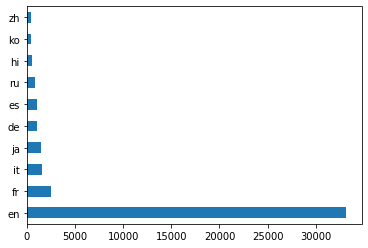

In [22]:
df['original_language'].value_counts()[0:10].plot(kind='barh');

In [23]:
df['original_language'] = df['original_language'].fillna('en')
df['tagline'] = df['tagline'].fillna('')
df['overview'] = df['overview'].fillna('')

In [24]:
vote_average = df['vote_average'].sum()/len(df['vote_average'])
vote_count = df['vote_count'].sum()/len(df['vote_count'])

df['vote_average'] = df['vote_average'].fillna(vote_average)
df['vote_count'] = df['vote_count'].fillna(vote_count)

In [25]:
df['popularity'] = df['popularity'].astype('float')

popularity = df['popularity'].sum()/len(df['popularity'])

df['popularity'] = df['popularity'].fillna(popularity)

In [26]:
df.isnull().sum()

adult                       0
original_language           0
original_title              0
overview                    0
popularity                  0
tagline                     0
vote_average                0
vote_count                  0
imdbId                      0
tmdbId                      0
new_genres                  0
new_production_companies    0
new_production_countries    0
new_spoken_languages        0
new_keywords                0
new_cast                    0
dtype: int64

In [27]:
df.head(2)

,adult,original_language,original_title,overview,popularity,tagline,vote_average,vote_count,imdbId,tmdbId,new_genres,new_production_companies,new_production_countries,new_spoken_languages,new_keywords,new_cast
0,False,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,,7.7,5415.0,114709,862,"'Animation', 'Comedy', 'Family'",'Pixar Animation Studios','United States of America','English',"'jealousy', 'toy', 'boy', 'friendship', 'frien...","'Tom Hanks', 'Tim Allen', 'Don Rickles', 'Jim ..."
1,False,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,Roll the dice and unleash the excitement!,6.9,2413.0,113497,8844,"'Adventure', 'Fantasy', 'Family'","'TriStar Pictures', 'Teitler Film', 'Interscop...",'United States of America',"'English', 'Français'","'board game', 'disappearance', ""based on child...","'Robin Williams', 'Jonathan Hyde', 'Kirsten Du..."


### Gather Texts for Natural Language Processing 

In [28]:
def combine_text(row):
    return (row['overview']+" "+row['new_genres']+" "+row['new_production_companies']+" "+
            row['new_production_countries']+" "+row['new_spoken_languages']+" "+
            row['new_keywords']+" "+row["new_cast"])

In [29]:
df['combine_text'] = df.apply(combine_text,axis = 1)

In [30]:
df['combine_text'] = df['combine_text'].apply(lambda x: x.lower())

In [31]:
df

,adult,original_language,original_title,overview,popularity,tagline,vote_average,vote_count,imdbId,tmdbId,new_genres,new_production_companies,new_production_countries,new_spoken_languages,new_keywords,new_cast,combine_text
0,False,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,,7.7,5415.0,114709,862,"'Animation', 'Comedy', 'Family'",'Pixar Animation Studios','United States of America','English',"'jealousy', 'toy', 'boy', 'friendship', 'frien...","'Tom Hanks', 'Tim Allen', 'Don Rickles', 'Jim ...","led by woody, andy's toys live happily in his ..."
1,False,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,Roll the dice and unleash the excitement!,6.9,2413.0,113497,8844,"'Adventure', 'Fantasy', 'Family'","'TriStar Pictures', 'Teitler Film', 'Interscop...",'United States of America',"'English', 'Français'","'board game', 'disappearance', ""based on child...","'Robin Williams', 'Jonathan Hyde', 'Kirsten Du...",when siblings judy and peter discover an encha...
2,False,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.712900,Still Yelling. Still Fighting. Still Ready for...,6.5,92.0,113228,15602,"'Romance', 'Comedy'","'Warner Bros.', 'Lancaster Gate'",'United States of America','English',"'fishing', 'best friend', 'duringcreditsstinge...","'Walter Matthau', 'Jack Lemmon', 'Ann-Margret'...",a family wedding reignites the ancient feud be...
3,False,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,Friends are the people who let you be yourself...,6.1,34.0,114885,31357,"'Comedy', 'Drama', 'Romance'",'Twentieth Century Fox Film Corporation','United States of America','English',"'based on novel', 'interracial relationship', ...","'Whitney Houston', 'Angela Bassett', 'Loretta ...","cheated on, mistreated and stepped on, the wom..."
4,False,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,Just When His World Is Back To Normal... He's ...,5.7,173.0,113041,11862,'Comedy',"'Sandollar Productions', 'Touchstone Pictures'",'United States of America','English',"'baby', 'midlife crisis', 'confidence', 'aging...","'Steve Martin', 'Diane Keaton', 'Martin Short'...",just when george banks has recovered from his ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46905,False,fa,رگ خواب,Rising and falling between a man and woman.,0.072051,Rising and falling between a man and woman,4.0,1.0,6209470,439050,"'Drama', 'Family'",,'Iran','فارسی','tragic love',"'Leila Hatami', 'Kourosh Tahami', 'Elham Korda'",rising and falling between a man and woman. 'd...
46906,False,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,0.178241,,9.0,3.0,2028550,111109,'Drama','Sine Olivia','Philippines','',"'artist', 'play', 'pinoy'","'Angel Aquino', 'Perry Dizon', 'Hazel Orencio'...",an artist struggles to finish his work while a...
46907,False,en,Betrayal,"When one of her hits goes wrong, a professiona...",0.903007,A deadly game of wits.,3.8,6.0,303758,67758,"'Action', 'Drama', 'Thriller'",'American World Pictures','United States of America','English',,"'Erika Eleniak', 'Adam Baldwin', 'Julie du Pag...","when one of her hits goes wrong, a professiona..."
46908,False,en,Satana likuyushchiy,"In a small town live two brothers, one a minis...",0.003503,,0.0,0.0,8536,227506,,'Yermoliev','Russia',,,"'Iwan Mosschuchin', 'Nathalie Lissenko', 'Pave...","in a small town live two brothers, one a minis..."


In [32]:
movie_star = df

In [33]:
movie_star.isnull().sum()

adult                       0
original_language           0
original_title              0
overview                    0
popularity                  0
tagline                     0
vote_average                0
vote_count                  0
imdbId                      0
tmdbId                      0
new_genres                  0
new_production_companies    0
new_production_countries    0
new_spoken_languages        0
new_keywords                0
new_cast                    0
combine_text                0
dtype: int64

In [34]:
df.to_csv("df.csv")

# Movie Collaborative Filtering Dataset

In [35]:
title = df[['original_title','tmdbId']]

In [36]:
print(ratings.isnull().sum())
ratings

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556
...,...,...,...,...
26024284,270896,58559,5.0,1257031564
26024285,270896,60069,5.0,1257032032
26024286,270896,63082,4.5,1257031764
26024287,270896,64957,4.5,1257033990


In [37]:
user = pd.merge(ratings, title, left_on='movieId', right_on='tmdbId',how='left')

In [38]:
user.sort_values(by = 'userId')

,userId,movieId,rating,timestamp,original_title,tmdbId
0,1,110,1.0,1425941529,Trois couleurs : Rouge,110.0
26,1,112552,5.0,1425941336,NaN,NaN
25,1,99114,4.0,1425941667,NaN,NaN
24,1,98809,0.5,1425942640,NaN,NaN
23,1,96821,5.0,1425941382,Cesare deve morire,96821.0
...,...,...,...,...,...,...
26046452,270896,1617,4.0,1257031794,NaN,NaN
26046453,270896,1641,4.0,1257034002,Forces of Nature,1641.0
26046454,270896,1653,3.5,1257033824,Diarios de motocicleta,1653.0
26046456,270896,1676,3.0,1257034447,Will Penny,1676.0


In [39]:
user.isnull().sum()

userId                   0
movieId                  0
rating                   0
timestamp                0
original_title    14587721
tmdbId            14587721
dtype: int64

In [40]:
user = pd.merge(ratings, title, left_on='movieId', right_on='tmdbId')

In [41]:
user

,userId,movieId,rating,timestamp,original_title,tmdbId
0,1,110,1.0,1425941529,Trois couleurs : Rouge,110
1,11,110,3.5,1231676989,Trois couleurs : Rouge,110
2,22,110,5.0,1111937009,Trois couleurs : Rouge,110
3,24,110,5.0,979870012,Trois couleurs : Rouge,110
4,29,110,3.0,1044020005,Trois couleurs : Rouge,110
...,...,...,...,...,...,...
11458895,270123,151509,3.0,1453527817,Trapped in the Closet: Chapters 23-33,151509
11458896,270123,159109,1.5,1465361347,The Rambler,159109
11458897,270123,159109,1.5,1465361347,The Rambler,159109
11458898,270694,165159,4.0,1476635117,Agenzia Riccardo Finzi... praticamente detective,165159


In [42]:
user = user.drop(columns = ['timestamp','tmdbId'],axis = 1)

In [43]:
user = user[['movieId','original_title','userId','rating']]

In [44]:
user.head()

,movieId,original_title,userId,rating
0,110,Trois couleurs : Rouge,1,1.0
1,110,Trois couleurs : Rouge,11,3.5
2,110,Trois couleurs : Rouge,22,5.0
3,110,Trois couleurs : Rouge,24,5.0
4,110,Trois couleurs : Rouge,29,3.0


In [45]:
user.to_csv("user.csv")